# Classification of dynamometer cards using K-mean algorithm

In [2]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
import os
import csv
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
from datetime import datetime
from sklearn.cluster import KMeans  
from sklearn.preprocessing import StandardScaler


In [4]:
def extract_data_from_line(filepath):
    try:
        with open(filepath, 'r') as file:
            lines = file.readlines()

        timestamp = lines[3].strip()
        filename = os.path.basename(filepath)
        well_name_match = re.match(r"(\S+)", filename)
        well_name = well_name_match.group(1) if well_name_match else "Unknown"

        data_points = int(lines[9].strip()) # Extract number of data points
        data = []
        for line in lines[10:]:
             try:
                 data.append(float(line.strip()))
             except ValueError:
                 continue
                 
        if data_points == 200:
            load_data = data[:200]
            displacement_data = data[200:400]
            load_data.extend([0] * (200 - len(load_data)))
            displacement_data.extend([0] * (200 - len(displacement_data)))
            returned_data = [timestamp, well_name] + load_data + displacement_data
            
        elif data_points == 100:
            load_data1 = data[:100]
            displacement_data1 = [0] * 100  # Fill with zeros
            load_data2 = data[100:200] # next set of 100 points, if any
            load_data2.extend([0] * (100 - len(load_data2)))
            displacement_data2 = [0] * 100 # Fill with zeros
            returned_data = [timestamp, well_name] + load_data1 + displacement_data1 + load_data2 + displacement_data2 #combine
        else:
             print("Number of data points not supported. ")
             return None

        return returned_data



    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None
    except Exception as e:
        print(f"Error processing file {filepath}: {e}")
        return None

In [5]:
def process_dat_files(directory, output_dir=None):
    """Processes .dat files in a directory and writes to CSV."""

    directory = directory.rstrip(os.sep)
    base_name = os.path.basename(directory)
    output_csv = f"{base_name}_output.csv"


    if output_dir:
       output_path = os.path.join(output_dir, output_csv)

    else:
       output_path = output_csv


    try:

        with open(output_path, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            # Define CSV headers for up to 400 data points (200 load + 200 displacement)
            headers = ["Date/Time", "Well Name"] + [f"Load {i + 1}" for i in range(200)] + [f"Displacement {i + 1}" for i in range(200)]
            writer.writerow(headers)


            for filename in os.listdir(directory):
                filepath = os.path.join(directory, filename)
                if filename.endswith(".dat"):
                    result = extract_data_from_line(filepath)
                    if result:

                        writer.writerow(result)
                    else:
                         print(f"Warning: Skipped file {filename} due to extraction issues. ")
    except Exception as e:
          print(f"Error writing to CSV: {e}")

In [6]:
process_dat_files(r'E:\ML Models\.DAT', r'E:\ML Models')

In [ ]:
def process_data(file_path):
    
    df_csv = pd.read_csv(file_path, header=0)
    df_csv = df_csv.dropna(axis=1, how='all')

    # Convert 'Date/Time' to datetime before sorting
    df_csv['Date/Time'] = pd.to_datetime(df_csv['Date/Time'], errors='coerce')  
    df_csv = df_csv.dropna(subset=['Date/Time']) 

    return df_csv

In [ ]:
file_path = r'E:\ML Models\.DAT_output.csv'
df_csv = process_data(file_path)
df_csv

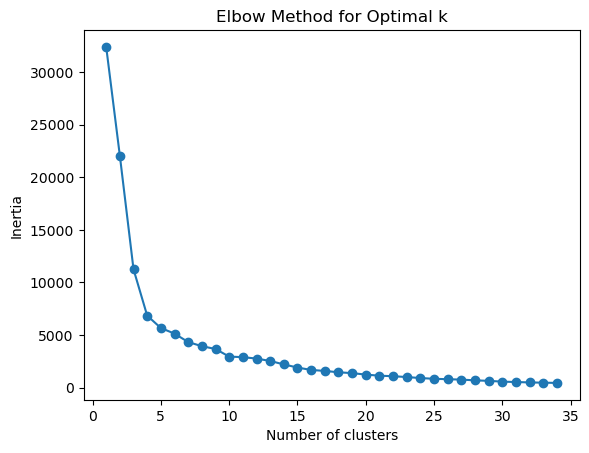

Cluster 0:
                 Date/Time        Load 1        Load 2        Load 3  \
count                   27     27.000000     27.000000     27.000000   
mean   2018-11-16 01:46:40  17848.740741  17902.222222  17975.629630   
min    2001-05-12 00:00:00  13849.000000  14159.000000  14413.000000   
25%    2015-09-27 00:00:00  16766.000000  16825.500000  16814.500000   
50%    2017-02-25 00:00:00  17884.000000  18072.000000  18079.000000   
75%    2024-10-09 00:00:00  18964.500000  18883.500000  18875.000000   
max    2024-11-12 00:00:00  22456.000000  22840.000000  22877.000000   
std                    NaN   1952.319342   1933.890645   1923.233278   

             Load 4        Load 5        Load 6        Load 7        Load 8  \
count     27.000000     27.000000     27.000000     27.000000     27.000000   
mean   18061.703704  18166.037037  18211.444444  18168.148148  18155.296296   
min    14402.000000  14442.000000  14679.000000  15040.000000  13925.000000   
25%    16863.000000  170

In [8]:
def unsupervised_model(df, n_clusters=5): 

    load_cols = [col for col in df if col.startswith('Load ')]
    disp_cols = [col for col in df if col.startswith('Displacement ')]
    
    # Combine load and displacement data for clustering
    X = df[load_cols + disp_cols].values  

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train the KMeans model
    kmeans = KMeans(n_clusters=n_clusters, random_state=42) 
    clusters = kmeans.fit_predict(X_scaled)

    return clusters, kmeans, scaler, X_scaled



optimal_n_clusters = 3 
clusters, kmeans_model, scaler, X_scaled = unsupervised_model(df_csv, n_clusters=optimal_n_clusters)


# Determine the optimal number of clusters 
inertia = []
for k in range(1, 35):  
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 35), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


#Add cluster labels to the DataFrame
df_csv['Cluster'] = clusters

# Analyze the clusters 
for i in range(optimal_n_clusters):
    cluster_data = df_csv[df_csv['Cluster'] == i]
    print(f"Cluster {i}:")
    print(cluster_data.describe()) 


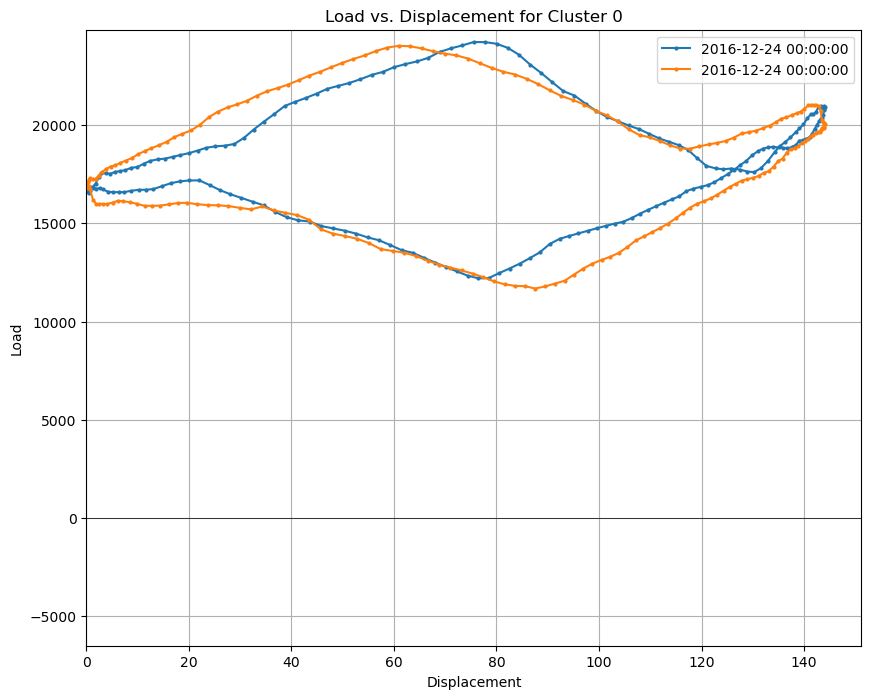

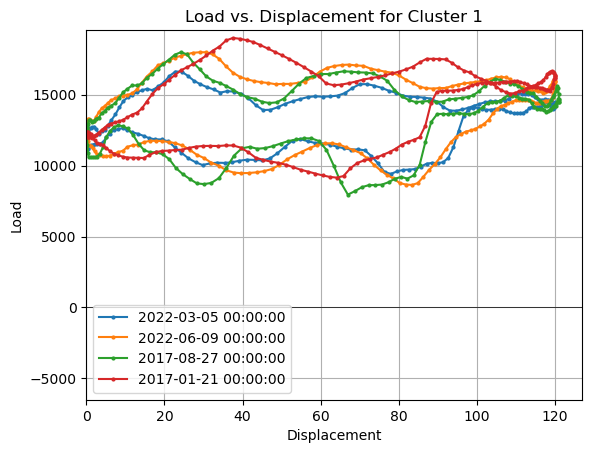

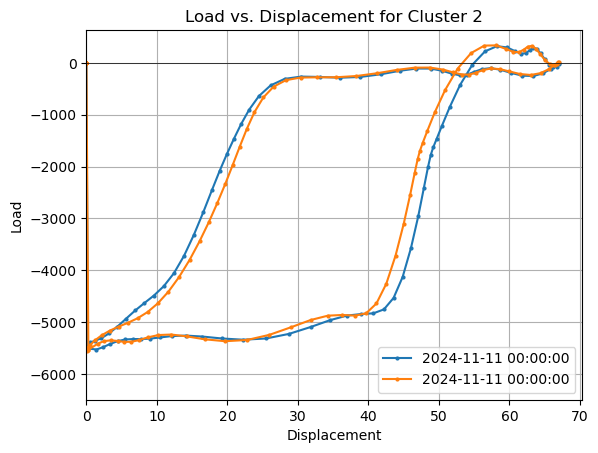

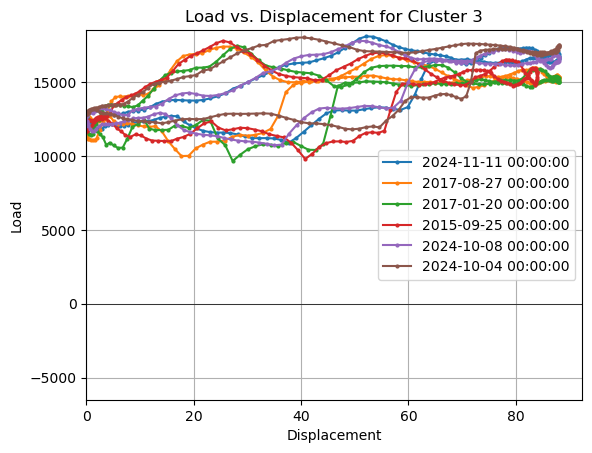

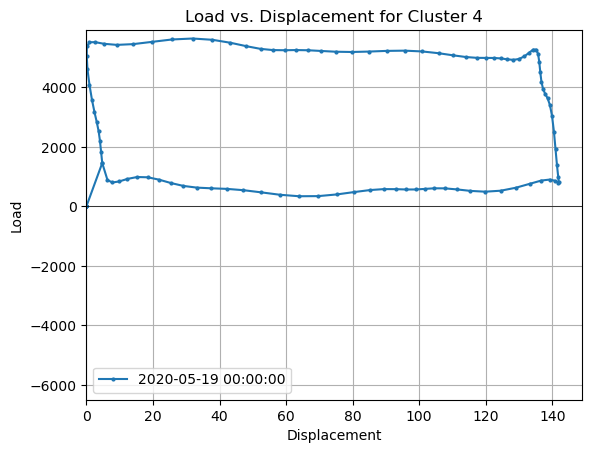

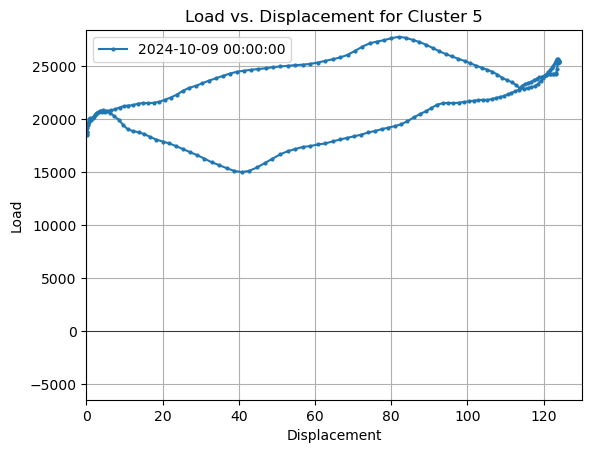

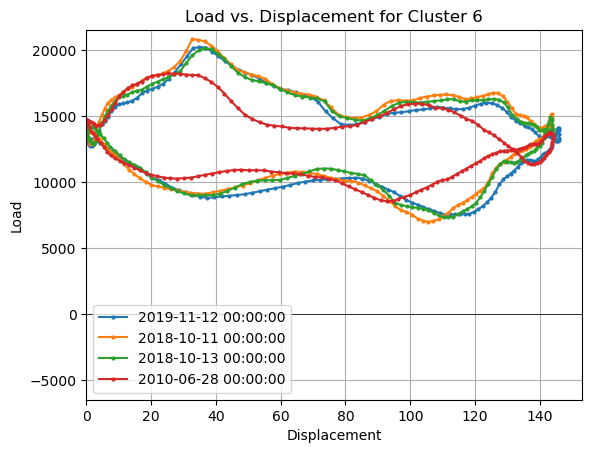

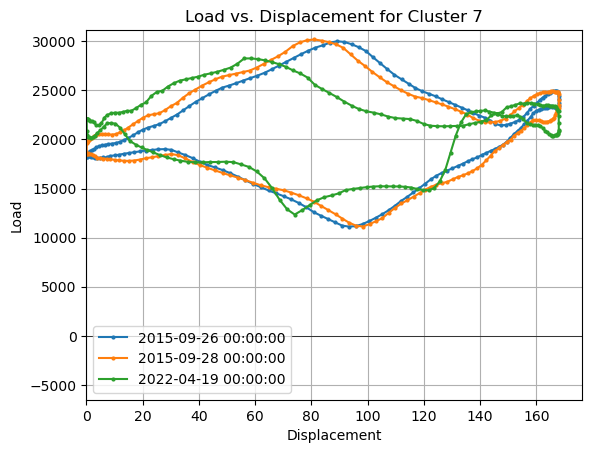

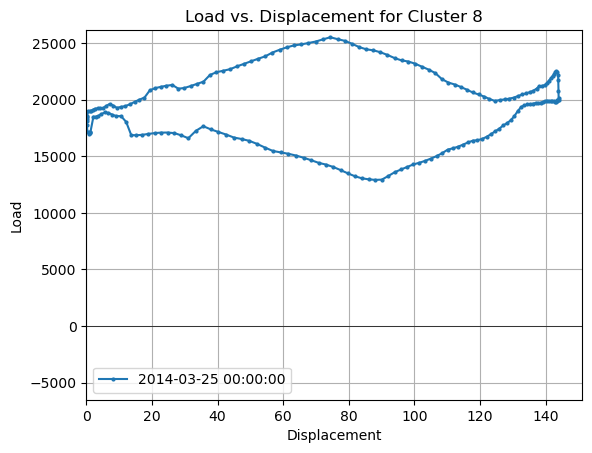

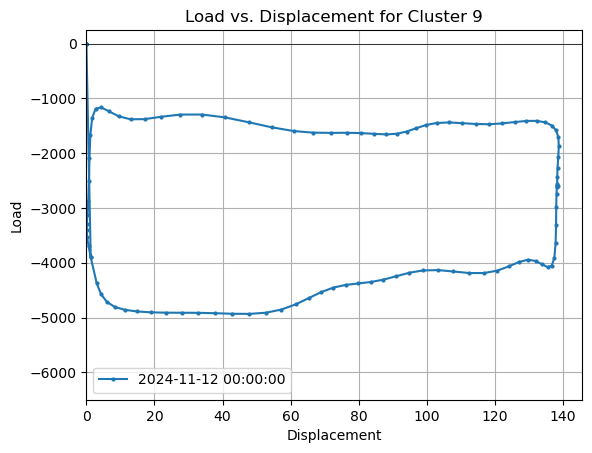

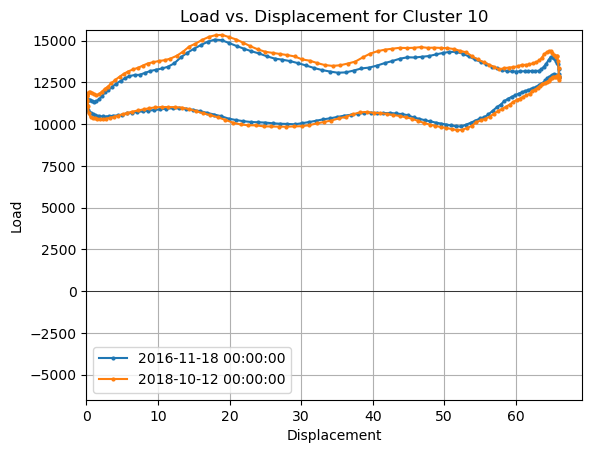

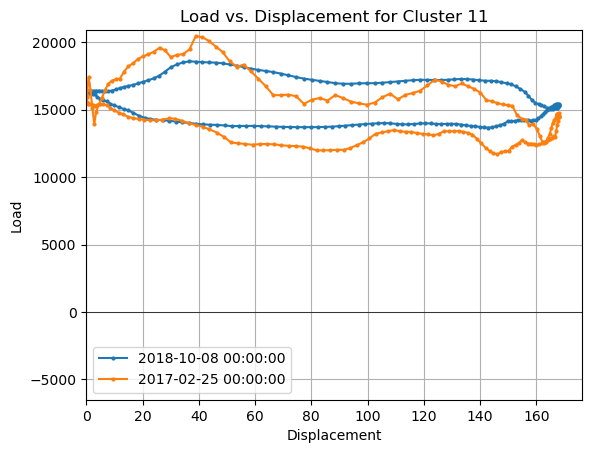

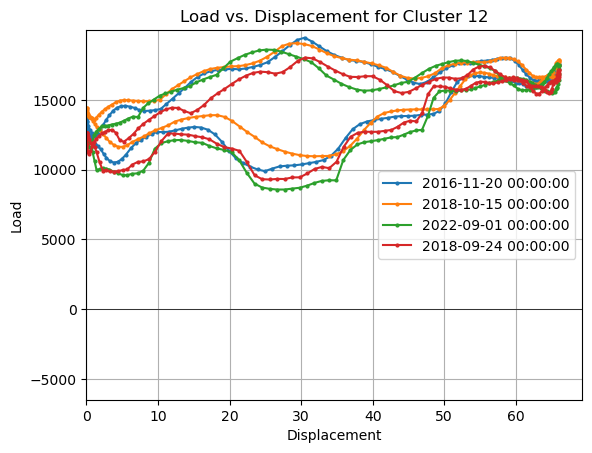

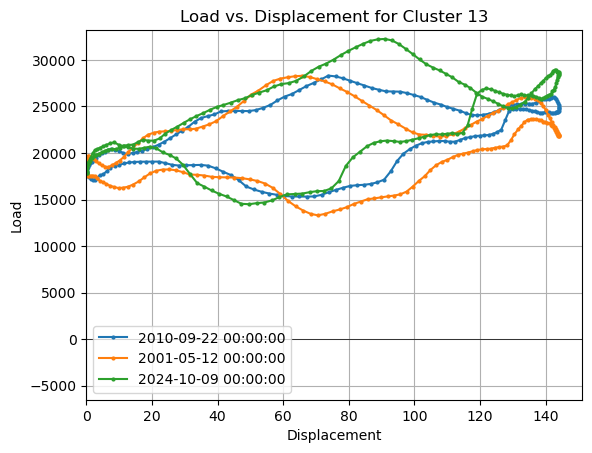

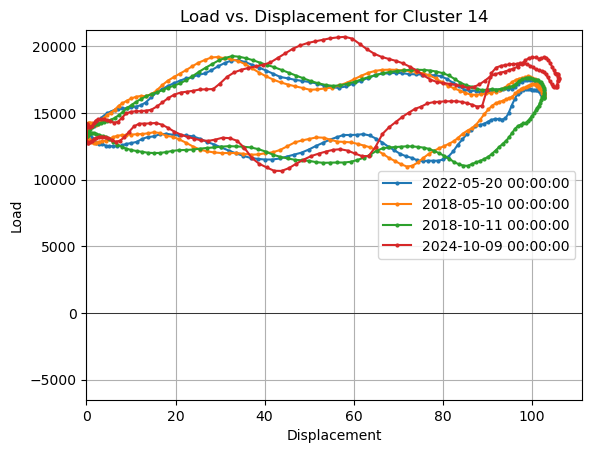

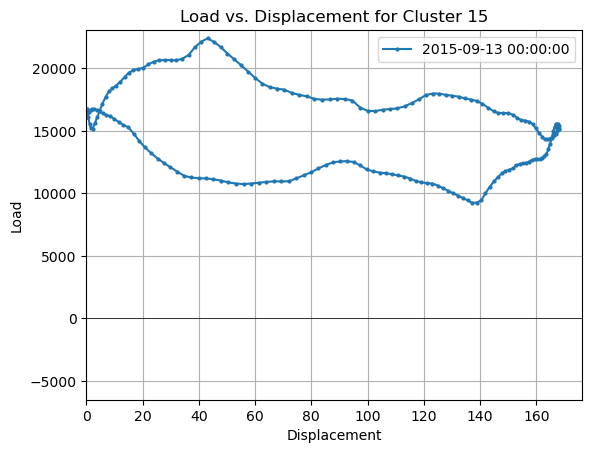

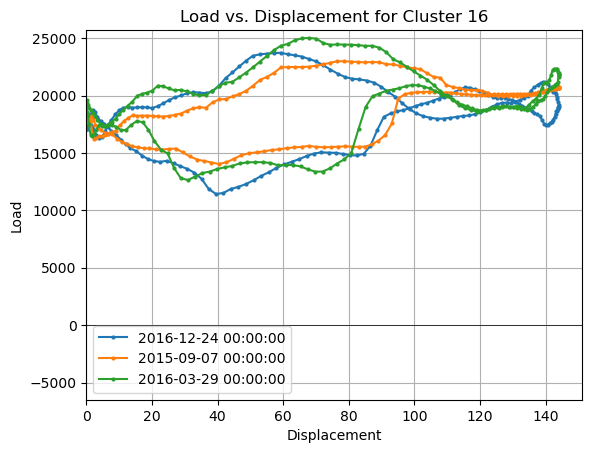

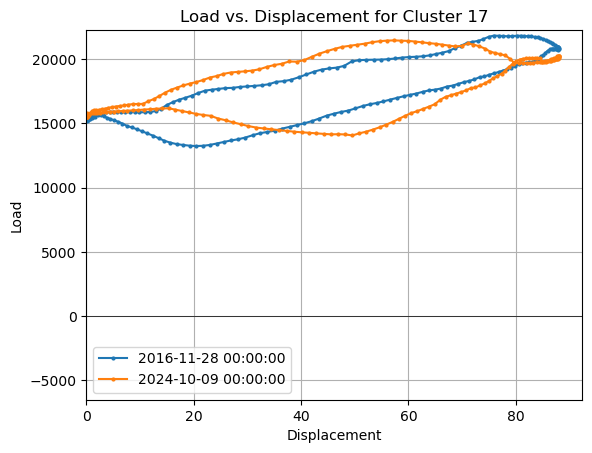

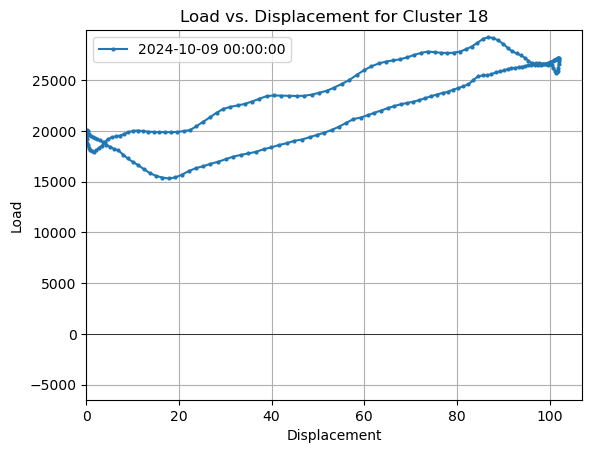

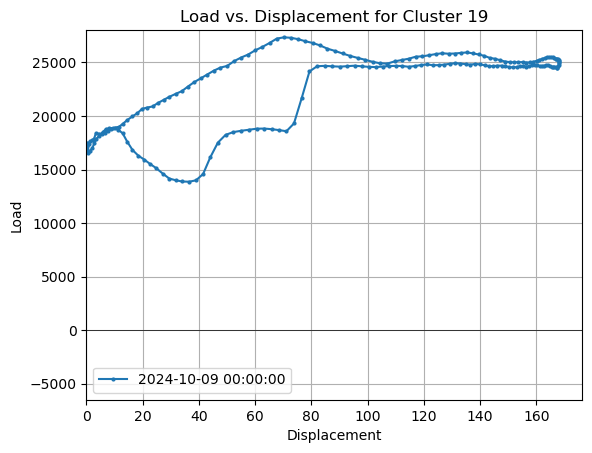

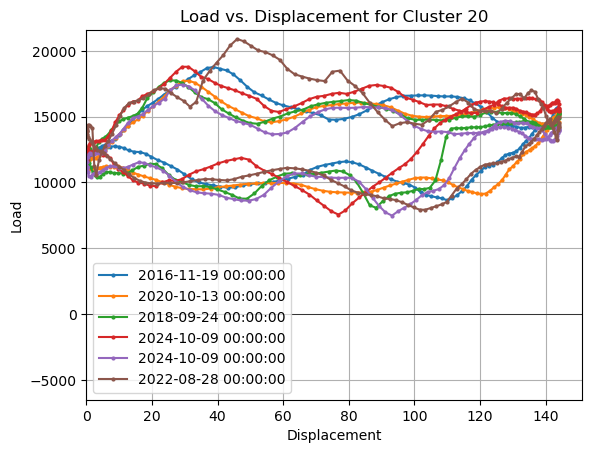

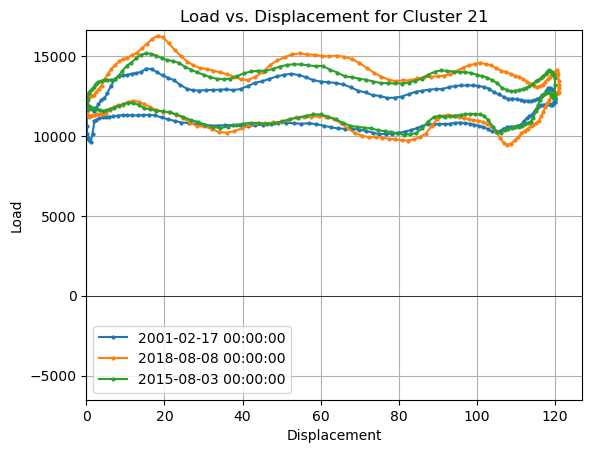

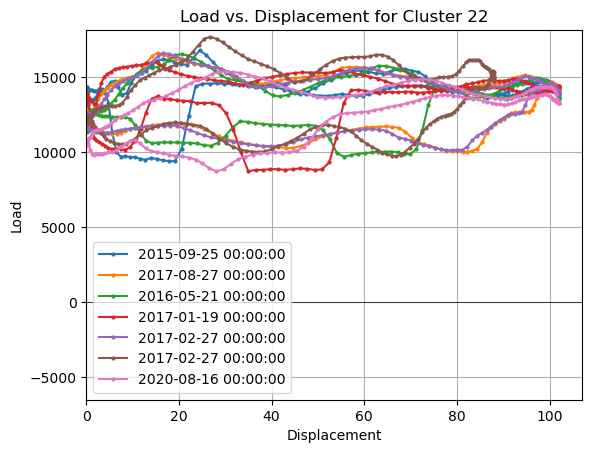

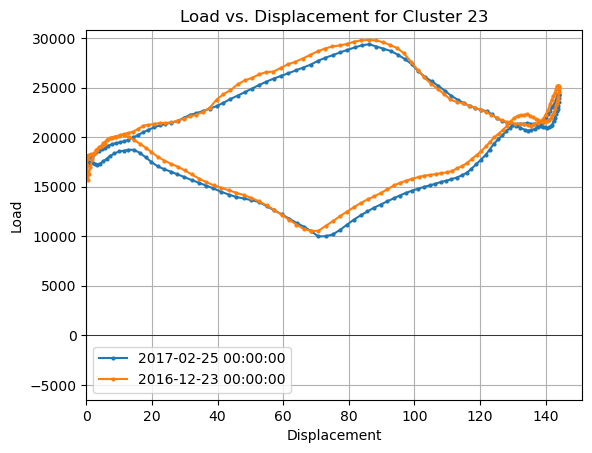

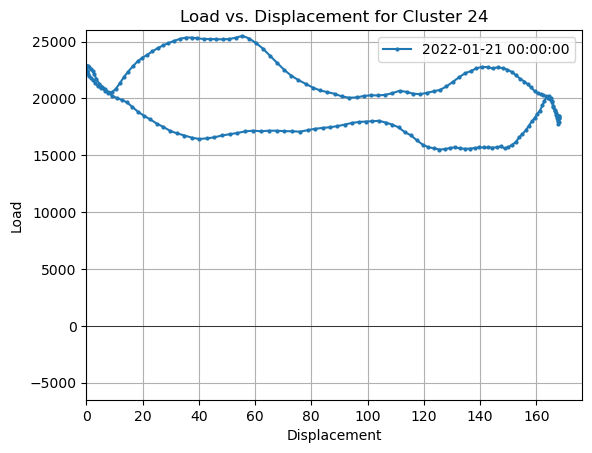

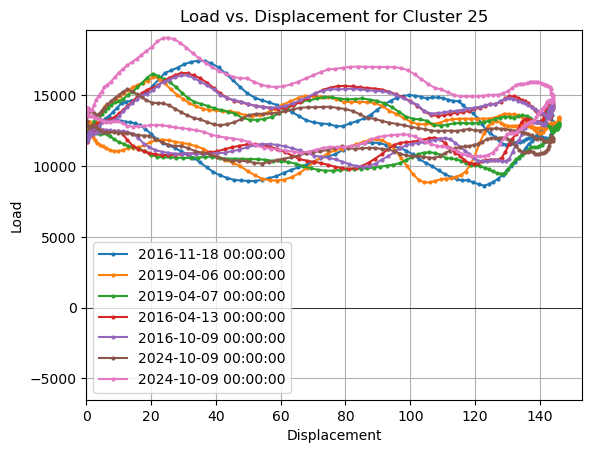

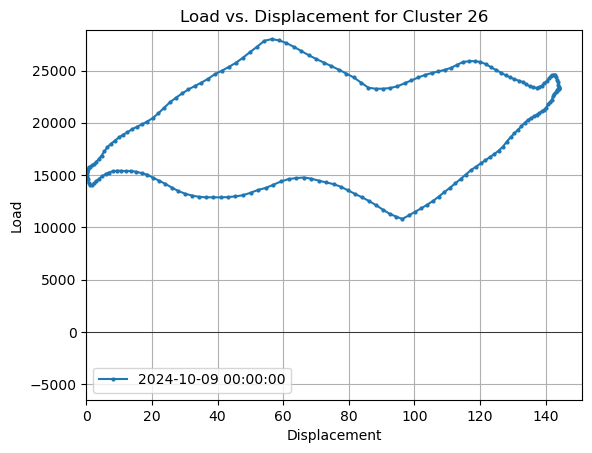

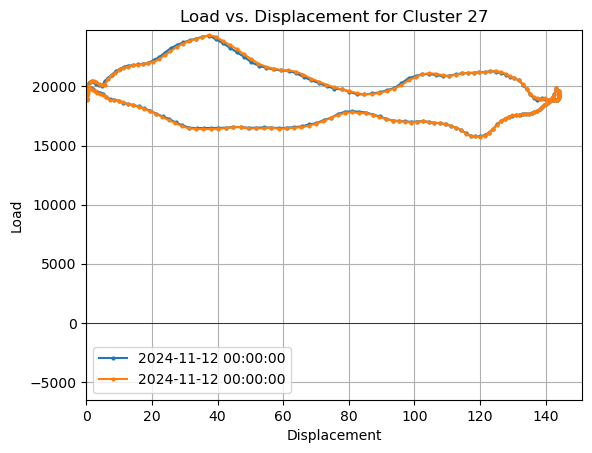

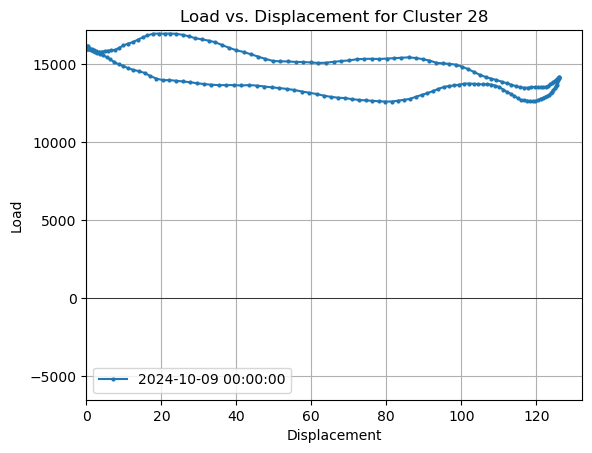

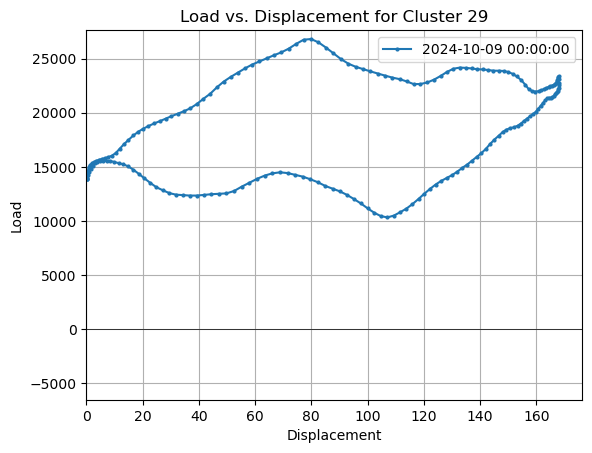

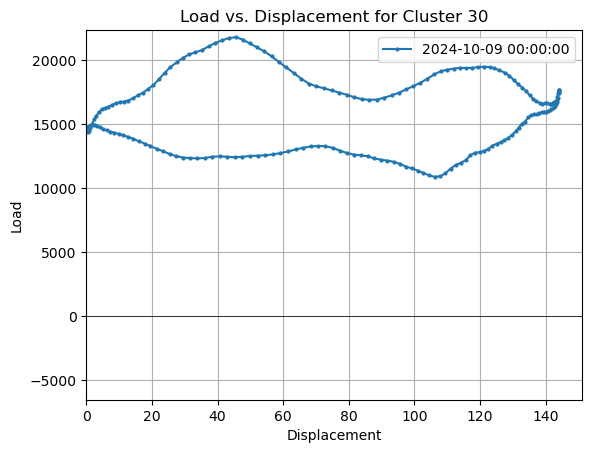

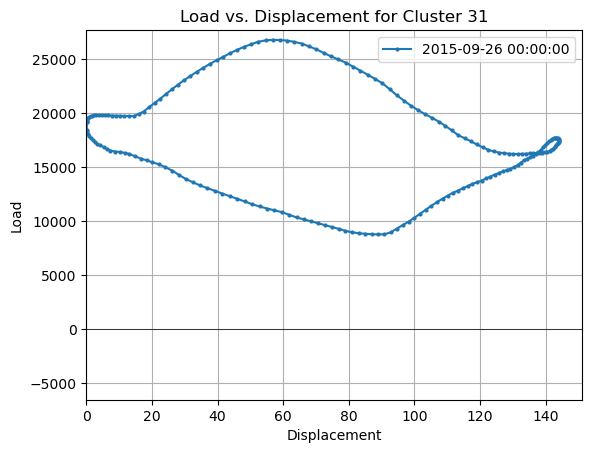

In [13]:
optimal_n_clusters = 32 

load_cols = [col for col in df_csv if col.startswith('Load')]
disp_cols = [col for col in df_csv if col.startswith('Displacement')]
X = df_csv[load_cols + disp_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)


df_csv['Cluster'] = clusters
# Adjust figure size as needed
plt.figure(figsize=(10, 8))  
for i in range(optimal_n_clusters):
    #filter original df based on clusters.
    cluster_data = df_csv[df_csv['Cluster'] == i] 
    for index, row in cluster_data.iterrows():
        #plot first 200 points
        plt.plot(row[disp_cols].iloc[:200], row[load_cols].iloc[:200], marker='o', markersize=2, label=row['Date/Time']) 

    plt.title(f"Load vs. Displacement for Cluster {i}")
    plt.xlabel('Displacement')
    plt.ylabel('Load')
    plt.grid(True)
    plt.legend()
    plt.xlim(left=0)
    plt.ylim(bottom=-6500)
    plt.axhline(0, color='black', lw=0.5)
    plt.axvline(0, color='black', lw=0.5)
    plt.show()